In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [4]:
print('Current cuda device is',device)

Current cuda device is cuda


## hyperParameter 지정

In [5]:
batch_size = 50
epoch_num = 15
learning_rate = 0.0001

In [6]:
mkdir data

In [7]:
train_data = datasets.MNIST(root = './data', train = True, download=True, transform = transforms.ToTensor())


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
test_data = datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

In [9]:
print('number of training data:', len(train_data))

number of training data: 60000


In [10]:
print('number of test data:', len(test_data))

number of test data: 10000


## MNIST   데이터 확인하기

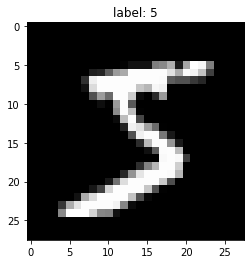

In [13]:
image, label = train_data[0]
plt.imshow(image.squeeze().numpy(),cmap='gray')
plt.title('label: %s'% label)
plt.show()

In [14]:
train_loader = torch.utils.data.DataLoader(dataset= train_data,batch_size=batch_size,shuffle= True)

In [15]:
test_loader = torch.utils.data.DataLoader(dataset = test_data,batch_size = batch_size,shuffle=True)

In [16]:
first_batch= train_loader.__iter__().__next__()

In [22]:
print('{:.15s}|{:<25s}|{}'.format('name','type','size'))
print('{:.15s}|{:<25s}|{}'.format('Num of Batch','',len(train_loader)))
print('{:.15s}|{:<25s}|{}'.format('first_batch',str(type(first_batch)),len(first_batch)))
print('{:.15s}|{:<25s}|{}'.format('first_batch[0]',str(type(first_batch[0])),first_batch[0].shape))
print('{:.15s}|{:<25s}|{}'.format('first_batch[1]',str(type(first_batch[1])),first_batch[1].shape))

name|type                     |size
Num of Batch|                         |1200
first_batch|<class 'list'>           |2
first_batch[0]|<class 'torch.Tensor'>   |torch.Size([50, 1, 28, 28])
first_batch[1]|<class 'torch.Tensor'>   |torch.Size([50])


In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,32,3,1)
        self.conv2 = nn.Conv2d(32,64,3,1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216,128)
        self.fc2 = nn.Linear(128,10)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x,dim=1)
        return output

## Optimizer 및 손실 함수 정의

In [30]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(),lr= learning_rate)
criterion = nn.CrossEntropyLoss()

## 설계한 CNN 모형 확인하기

In [31]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 모델 학습

In [32]:
model.train()
i = 0 
for epoch in range(epoch_num):
    for data,target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output=model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('Train Step:{}/tLoss: {:.3f}'.format(i,loss.item()))
        i+=1

Train Step:0/tLoss: 2.309
Train Step:1000/tLoss: 0.299
Train Step:2000/tLoss: 0.105
Train Step:3000/tLoss: 0.160
Train Step:4000/tLoss: 0.181
Train Step:5000/tLoss: 0.102
Train Step:6000/tLoss: 0.149
Train Step:7000/tLoss: 0.049
Train Step:8000/tLoss: 0.040
Train Step:9000/tLoss: 0.138
Train Step:10000/tLoss: 0.052
Train Step:11000/tLoss: 0.019
Train Step:12000/tLoss: 0.107
Train Step:13000/tLoss: 0.029
Train Step:14000/tLoss: 0.129
Train Step:15000/tLoss: 0.014
Train Step:16000/tLoss: 0.014
Train Step:17000/tLoss: 0.210


## 모델 평가

In [33]:
model.eval()
correct = 0 
for data,target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()
    
print('Test set: Accuracy: {:.2f}%'.format(100 * correct / len(test_loader.dataset)))

Test set: Accuracy: 98.92%
